<a href="https://colab.research.google.com/github/konqstorm/YADRO_Hack/blob/main/YADROHack_Trshchnk_Dbnkn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Загрузка библиотек и данных

In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse, mean_absolute_error as mae
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Доустанавливаем дополнительные библиотеки, если они не установлены
try:
  from xgboost import XGBRegressor
except ModuleNotFoundError:
  !pip install xgboost
  from xgboost import XGBRegressor
try:
  from catboost import CatBoostRegressor
except ModuleNotFoundError:
  !pip install catboost
  from catboost import CatBoostRegressor

In [2]:
# Клонируем репозиторий, чтобы не загружать данные вручную
!git clone https://github.com/dkurt/weather_forecast_hackathon.git

Cloning into 'weather_forecast_hackathon'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (29/29), done.
remote: Total 35 (delta 8), reused 25 (delta 4), pack-reused 0
Receiving objects: 100% (35/35), 95.19 KiB | 1.17 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [3]:
df = pd.DataFrame()
data_folder = '/content/weather_forecast_hackathon/data/'
# Перечисляем вручную, потому что через listdir будет не тот порядок
files = ['temperature.npy', 'pressure.npy', 'humidity.npy', 'wind_speed.npy', 'wind_dir.npy', 'cloud_cover.npy']

# Создем DataFrame сразу на 48 часов, затем распилим его на 43 известных и 5 предсказываемых
# Делаем сетку, пробегающую все комбинации по часам и координатам
n_hours = 48
time, y, x = np.meshgrid(np.arange(n_hours),
                      np.arange(1, 31),
                      np.arange(1, 31),
                      indexing='ij')

# Дополнительно распиливаем время в часах на номер дня (1 или 2) и час по 24-часовой системе
# Это сделано для того, чтобы обучать деревья на этих данных
# (иначе наши новые часы просто свялятся в последнее условие дерева по времени)
df['day'] = time.flatten() // 24 + 1
df['time'] = time.flatten() % 24
df['y'] = y.flatten()
df['x'] = x.flatten()
# Высоты размножили для каждого часа
df['z'] = np.tile(np.load(data_folder + 'elevation.npy').reshape(-1), n_hours)

# Проходимся по всем файлам, раскатываем данные в столбец и прицепляем снизу нули
for file in files:
  loaded_arr = np.load(data_folder + file)
  column = np.hstack((loaded_arr.reshape(-1), np.zeros(900 * (n_hours - 43))))
  df[file.split('.')[0]] = column

# Распиливаем на известные данные и выходные (пока) нули
input_df = df.iloc[:900 * 43, :]
output_df = df.iloc[900 * 43:, :].reset_index(drop=True)

# Анализ данных

In [4]:
# Проверяем датафреймы
input_df

,day,time,y,x,z,temperature,pressure,humidity,wind_speed,wind_dir,cloud_cover
0,1,0,1,1,129.0,19.900000,1006.000000,74.0,20.1,111.0,2.0
1,1,0,1,2,116.0,20.000000,1006.000000,74.0,20.1,111.0,2.0
2,1,0,1,3,113.0,20.000000,1006.000000,74.0,20.1,111.0,2.0
3,1,0,1,4,115.0,19.400000,1006.299988,73.0,18.4,107.0,3.0
4,1,0,1,5,122.0,19.299999,1006.299988,73.0,18.4,107.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...
38695,2,18,30,26,134.0,21.600000,1000.299988,85.0,9.3,28.0,14.0
38696,2,18,30,27,110.0,21.700001,1000.400024,83.0,5.4,37.0,26.0
38697,2,18,30,28,109.0,21.700001,1000.400024,83.0,5.4,37.0,26.0
38698,2,18,30,29,124.0,21.600000,1000.400024,83.0,5.4,37.0,26.0


In [5]:
output_df

,day,time,y,x,z,temperature,pressure,humidity,wind_speed,wind_dir,cloud_cover
0,2,19,1,1,129.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,19,1,2,116.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,19,1,3,113.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2,19,1,4,115.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,19,1,5,122.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4495,2,23,30,26,134.0,0.0,0.0,0.0,0.0,0.0,0.0
4496,2,23,30,27,110.0,0.0,0.0,0.0,0.0,0.0,0.0
4497,2,23,30,28,109.0,0.0,0.0,0.0,0.0,0.0,0.0
4498,2,23,30,29,124.0,0.0,0.0,0.0,0.0,0.0,0.0


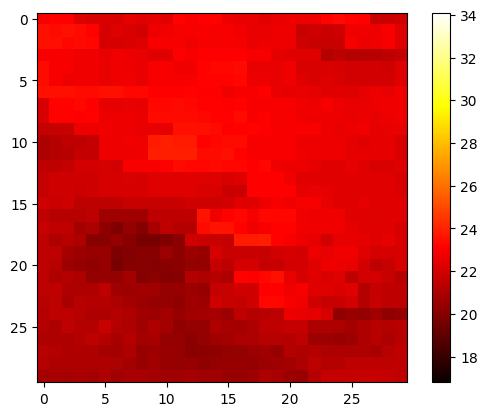

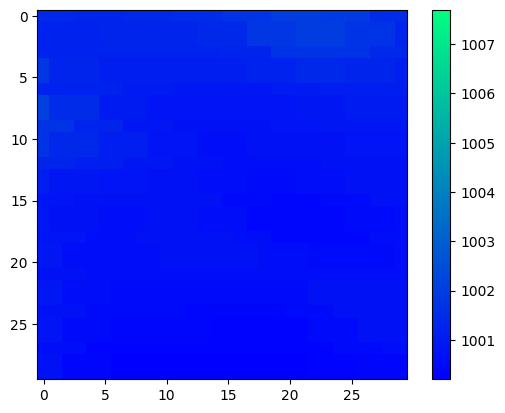

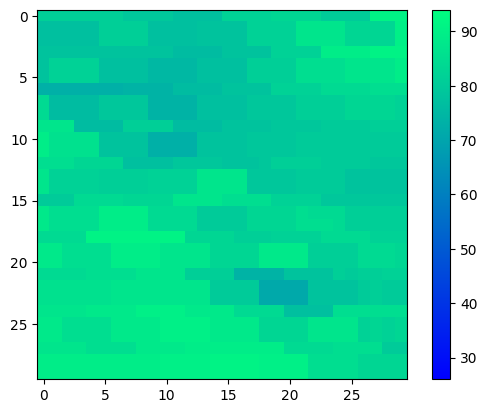

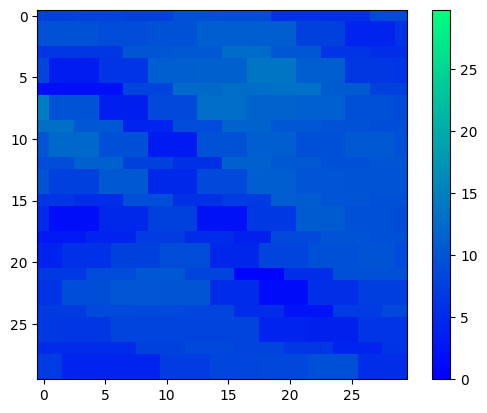

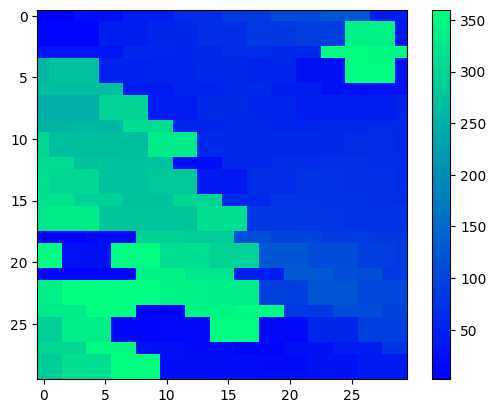

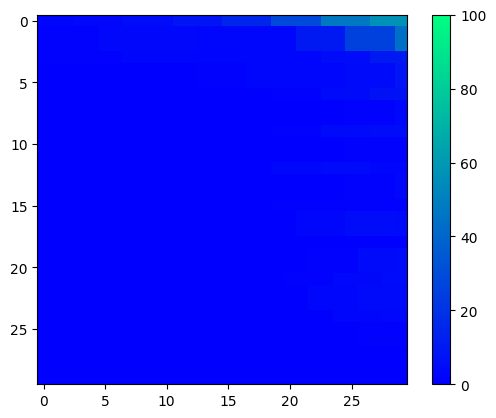

In [6]:
# Этот кусок кода визуализирует и сохраняет предсказываемые данные в виде gif

# Функция отвечает за отрисовку одного кадра, сделана через partials,
# чтобы можно было менять данные на входе и при этом все равно передавать ее в FuncAnimation
def partial_animation(data: np.ndarray, colormap: str) -> callable:
  def update_animation(frame: int) -> None:
    plt.clf()
    # Минимальное и максимальное значения задаем, чтобы шкала не прыгала между кадрами
    plt.imshow(data[frame, :, :], cmap=colormap, interpolation='nearest', vmin=np.min(data), vmax=np.max(data))
    plt.colorbar()
  return update_animation

os.mkdir('/content/gifs/')
for file in files:
  loaded_arr = np.load(data_folder + file)

  # Разные палитры для разных данных просто для красоты
  colormap = 'viridis'
  if file == 'temperature.npy':
    colormap = 'hot'
  elif file == 'wind_speed.npy' or 'wind_dir.npy':
    colormap = 'winter'

  fig = plt.figure()
  ani = FuncAnimation(fig, partial_animation(loaded_arr, colormap), frames=range(loaded_arr.shape[0]), interval=200)
  ani.save('/content/gifs/' + file.split('.')[0] + '_animation.gif', writer='pillow')

# | я не знаю, как это убрать, но оно бесполезно (тут просто последние кадры), все гифки сохранены и находятся слева
# V

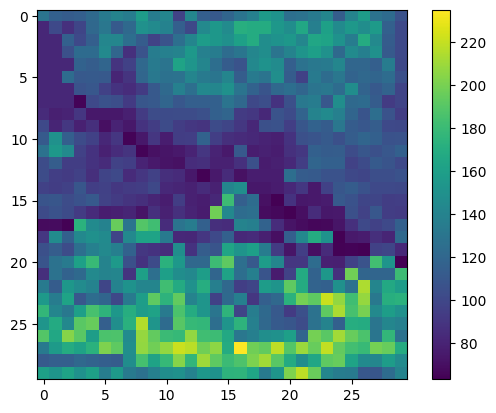

In [102]:
# Смотрим, как выглядит карта высот
elev = np.load(data_folder + 'elevation.npy')
plt.imshow(elev, cmap='viridis')
plt.colorbar()

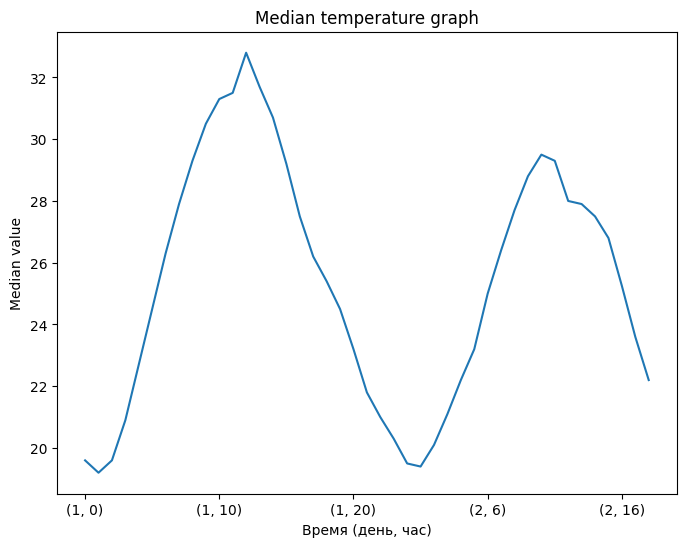

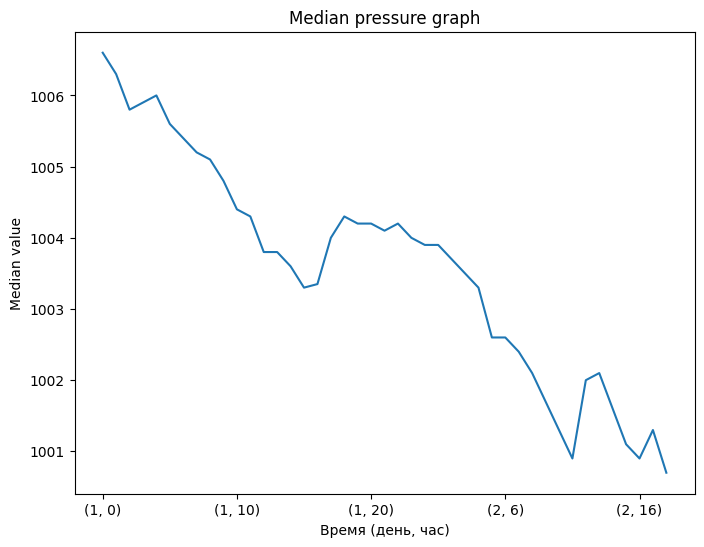

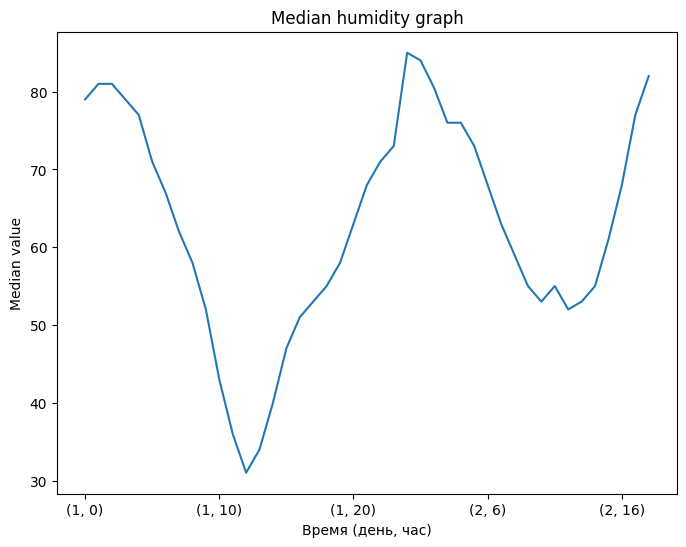

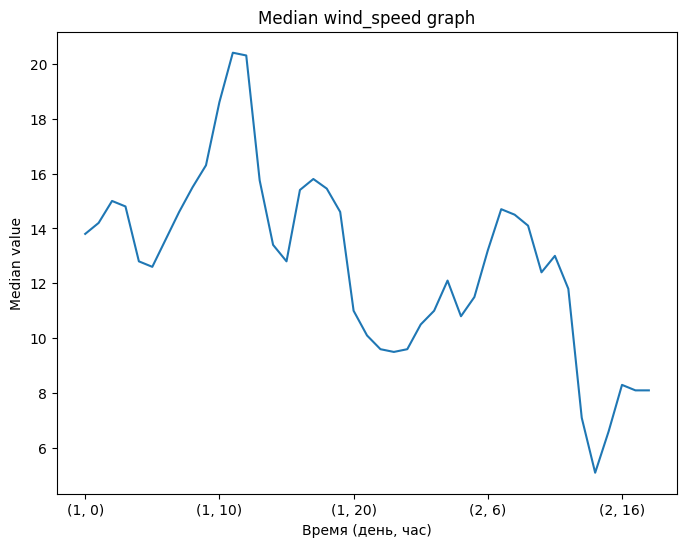

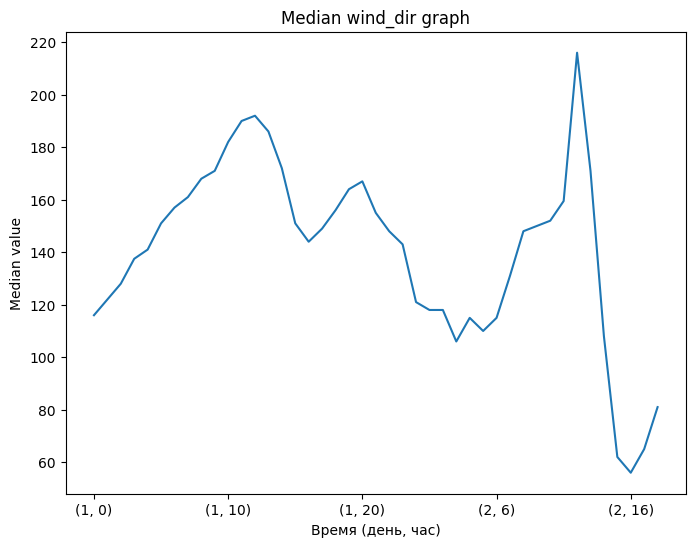

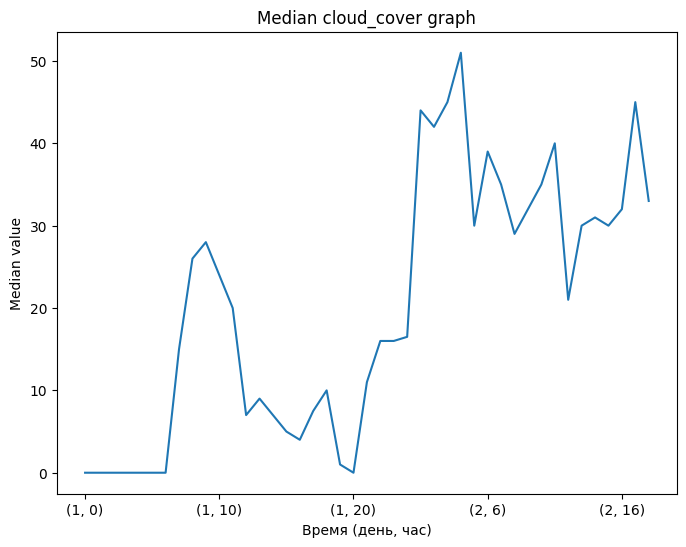

In [232]:
# Как меняется медиана каждого признака (почему мы везде в этой задаче используем медианы - ниже)
grouped = input_df.drop(columns=['x','y','z']).groupby(['day', 'time']).median()
columns_to_plot = ['temperature', 'pressure', 'humidity', 'wind_speed', 'wind_dir', 'cloud_cover']

for col in columns_to_plot:
    plt.figure(figsize=(8, 6))
    grouped[col].plot()
    plt.title(f'Median {col} graph')
    plt.xlabel('Время (день, час)')
    plt.ylabel('Median value')

Если мы посмотрим полученные gif-ки и графики, то по ним видно, что температура и влажность меняются примерно соответственно суточным ритмам. На основе этого предполагаем, что их можно будет обработать как time-series данные. Предварительно для них в качестве базовых моделей возьмем градиентный бустинг и случайный лес, в качестве продвинутой -- RNN.

Давление меняется регрессионно -- будем использовать линейную регрессию, либо так же "деревянные" решения.

Данные по облачности и ветру выглядят сильно распредленными и довольно случайными. В качестве базового решения будем предсказывать их по treshold-у, который выберем исходя из метрики качества. Также попробуем посчитать ковариацию этих данных с остальными и, возможно, попробуем предсказывать их на основе предсказаний для первых трех

In [8]:
# Теперь смотрим, как распределены входные данные
input_df.describe()

,day,time,y,x,z,temperature,pressure,humidity,wind_speed,wind_dir,cloud_cover
count,38700.000000,38700.000000,38700.000000,38700.000000,38700.000000,38700.000000,38700.000000,38700.000000,38700.000000,38700.000000,38700.000000
mean,1.441860,10.395349,15.500000,15.500000,123.945557,25.320974,1003.612028,62.899948,12.809393,144.326202,21.193953
std,0.496615,6.445343,8.655553,8.655553,36.028423,3.994402,1.601819,14.660645,4.048162,41.743641,19.025041
min,1.000000,0.000000,1.000000,1.000000,63.000000,16.799999,1000.200012,26.000000,0.000000,2.000000,0.000000
25%,1.000000,5.000000,8.000000,8.000000,95.000000,21.600000,1002.299988,53.000000,10.200000,125.000000,4.000000
50%,1.000000,10.000000,15.500000,15.500000,118.500000,25.500000,1003.799988,63.000000,13.000000,149.000000,19.000000
75%,2.000000,16.000000,23.000000,23.000000,147.000000,28.400000,1004.599976,74.000000,15.300000,166.000000,33.000000
max,2.000000,23.000000,30.000000,30.000000,235.000000,34.099998,1007.700012,94.000000,29.799999,360.000000,100.000000


В нашем слуае мы считаем итоговую метрику как $MAPE$ по двумерной матрице ответов:

$MAPE = \frac{1}{N} \sum_{i=1}^{n} \sum_{j=1}^{m} \left| \frac{y_{ij} - \hat{y}_{ij}}{y_{ij}} \right|$

При этом очевидно, что, зафиксировав каждое значение $i$ и учитывая, что $N = nm$, мы можем представить ее как среднюю $MAPE$ по столбцам:

$MAPE = \frac{1}{n} \sum_{i=1}^{n} MAPE_i$

Таким образом, для оптимизации итоговой метрики нам нужно оптимизировать ее по каждому столбцу. Идея очевидная, но для нас это означает, что если мы будем (а мы действительно будем) предсказывать какие-то отдельные значения сильно лучше других, дальнейшее их уточнение даст нам куда меньший итоговый выигрыш, чем уточнение "проблемных" столбцов.

Теперь выберем treshold-значения. Нам нужно такое константное решение $c$, которое позволит минимизировать $MAPE$ по столбцу, то есть решение:

$MAPE(f, X, y) = \mathscr{L}(f, X, y) = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - c}{y_i} \right| \rightarrow \underset{c}{\text{min}}$

Для его нахождения ищем экстремум:

$\nabla_c\mathscr{L}(f, X, y) = \frac{1}{n} \sum_{i=1}^{n} sign(\frac{y_i - c}{y_i}) = 0$

Это равенство справедливо, когда выше $c$ лежит столько же значений $y_i$, сколько и ниже. Следовательно, наше оптимальное значение $c$ -- это медиана. Поэтому treshold-значения будем выбирать как медиану нужного столбца по всем клеткам за последний час. В дальнейшем попробуем построить регрессию по медианным значениям за каждый час и предсказывать по ней.

<Axes: >

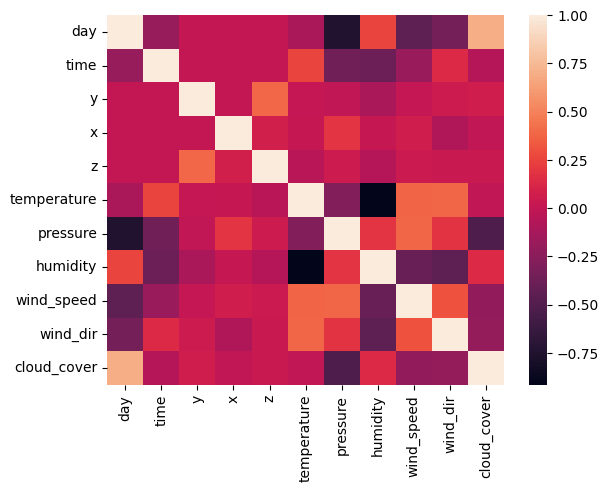

In [9]:
# Считаем корреляции. В принципе, уже по графикам было видно, что температура и влажность отрицательно коррелируют
corr_matrix = input_df.corr()
sns.heatmap(corr_matrix)

# Обработка данных

In [10]:
x_cols = ['day', 'time', 'y', 'x',] # Почему-то учет высоты (z) ухудшает предсказания, так что ее решили не брать
y_cols = ['temperature', 'pressure', 'humidity', 'wind_speed', 'wind_dir', 'cloud_cover']

X = np.array(input_df[x_cols])
Y = np.array(input_df[y_cols])
# Единичка, чтобы убрать нули и не ловить огромную MAPE
# НЕ ЗАБЫТЬ ВЫЧЕСТЬ В КОНЦЕ
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y + 1, test_size=0.25, random_state=0)

In [11]:
# Задаем пул простых моделей
simple_models = [LinearRegression(), RandomForestRegressor(), XGBRegressor(criterion=mape), CatBoostRegressor(loss_function='MAPE', verbose=0)]
simple_models_names = ['Линейная регрессия', 'Случайный лес', 'XG-Boost', 'CatBoost']

In [12]:
# Строим RNN модель
RNN = Sequential()

RNN.add(LSTM(units=50, return_sequences = True, input_shape=(X_train.shape[1], 1)))
RNN.add(Dropout(0.2))

RNN.add(LSTM(units=50, return_sequences = True))
RNN.add(Dropout(0.2))

RNN.add(LSTM(units=50, return_sequences = True))
RNN.add(Dropout(0.2))

RNN.add(LSTM(units=50))
RNN.add(Dropout(0.2))

RNN.add(Dense(units=1))

RNN.compile(optimizer='adam', loss='mean_squared_error')

In [16]:
# Маленькая функция для безопасного сохранения данных, чтобы
# не перезаписывать себя же и не переобучать потом нейронку по полчаса из-за этого
saving_dir_name = '/content/processed_data/'
os.mkdir(saving_dir_name)
def safe_save(file_name, array_to_save):
  while os.path.exists(saving_dir_name + file_name + '.npy'):
      if file_name[file_name.rfind('_') + 1:].isdigit():
          version = int(file_name[file_name.rfind('_') + 1:])
          file_name = file_name[:file_name.rfind('_') + 1] + str(version + 1)
      else:
          file_name = file_name + '_1'
  np.save(saving_dir_name + file_name, array_to_save)

# Температура

In [13]:
y_temp_train, y_temp_valid = Y_train[:, 0], Y_valid[:, 0]

# Тестируем простые модели
for i, model in enumerate(simple_models):
  print('Модель', simple_models_names[i])
  model.fit(X_train, y_temp_train)
  print('MAPE on train:     ', mape(y_temp_train, model.predict(X_train)))
  print('MAPE on validation:', mape(y_temp_valid, model.predict(X_valid)))
  print()

Модель Линейная регрессия
MAPE on train:      0.1306873930607974
MAPE on validation: 0.1319994045960414

Модель Случайный лес
MAPE on train:      0.001973779215924481
MAPE on validation: 0.005408247765133007

Модель XG-Boost
MAPE on train:      0.004976274713740796
MAPE on validation: 0.005689957901703988

Модель CatBoost
MAPE on train:      0.008373532357272164
MAPE on validation: 0.008576696334532879



In [15]:
# Теперь задействуем RNN. Для этого придется немного преобразовать данные
X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_valid_reshaped = X_valid.reshape(X_valid.shape[0], X_valid.shape[1], 1)

history_temp = RNN.fit(X_train_reshaped, y_temp_train, validation_data=(X_valid_reshaped, y_temp_valid), epochs=100, batch_size=32)

Epoch 1/100
908/908 [==============================] - 32s 17ms/step - loss: 70.3948 - val_loss: 15.9508
Epoch 2/100
908/908 [==============================] - 15s 16ms/step - loss: 19.4567 - val_loss: 15.8840
Epoch 3/100
908/908 [==============================] - 14s 16ms/step - loss: 11.1375 - val_loss: 1.7911
Epoch 4/100
908/908 [==============================] - 16s 17ms/step - loss: 5.4123 - val_loss: 0.9483
Epoch 5/100
908/908 [==============================] - 14s 16ms/step - loss: 4.8389 - val_loss: 1.1627
Epoch 6/100
908/908 [==============================] - 15s 16ms/step - loss: 4.5445 - val_loss: 0.6162
Epoch 7/100
908/908 [==============================] - 14s 16ms/step - loss: 4.3870 - val_loss: 0.5340
Epoch 8/100
908/908 [==============================] - 14s 15ms/step - loss: 4.2012 - val_loss: 0.5207
Epoch 9/100
908/908 [==============================] - 15s 17ms/step - loss: 4.0985 - val_loss: 0.4749
Epoch 10/100
908/908 [==============================] - 15s 16ms/ste

908/908 [==============================] - 4s 5ms/step
MAPE on train:      0.010537361580977808
303/303 [==============================] - 2s 5ms/step
MAPE on validation: 0.010712377233502058


<Axes: title={'center': 'Кривая обучения (температура)'}>

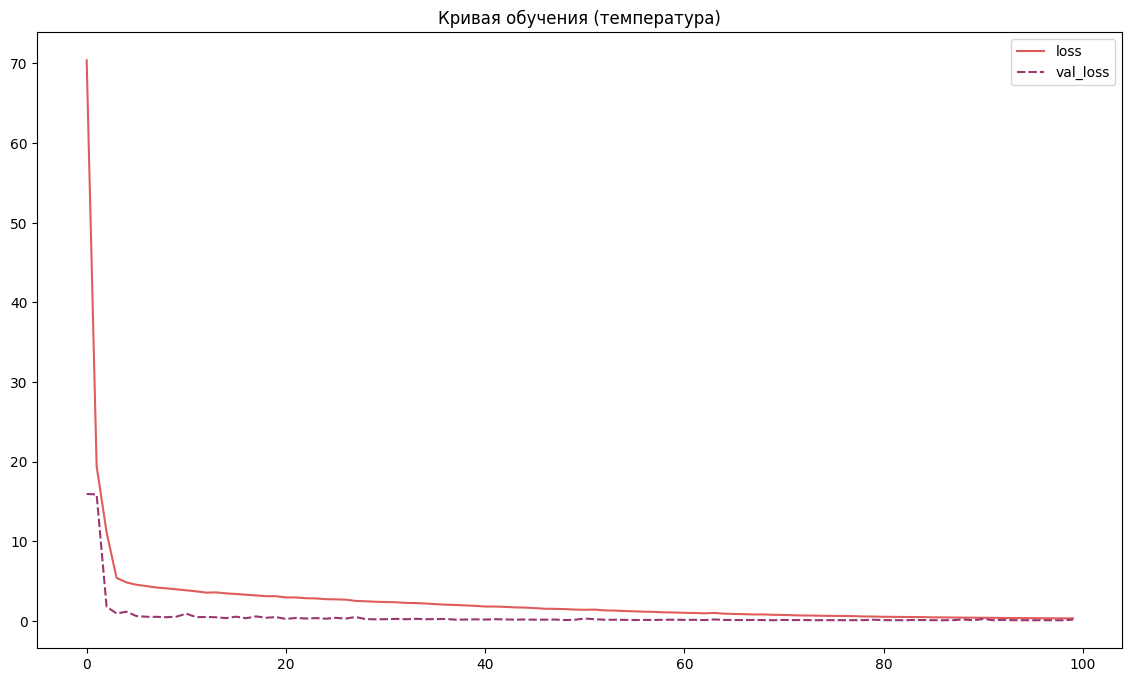

In [30]:
# Строим кривую обучения модели
print('MAPE on train:     ', mape(y_temp_train, RNN.predict(X_train_reshaped)))
print('MAPE on validation:', mape(y_temp_valid, RNN.predict(X_valid_reshaped)))

his_temp = pd.DataFrame(history_temp.history)
history_loss_temp = his_temp[['loss', 'val_loss']]

plt.figure(figsize=(14,8))
plt.title('Кривая обучения (температура)')
sns.lineplot(history_loss_temp, palette='flare')

In [29]:
# Сохраняем предсказания, так как в дальнейшем мы переиспользуем эту модель
X_forward = np.array(output_df[x_cols])
temp_prediction = RNN.predict(X_forward.reshape(X_forward.shape[0], X_forward.shape[1], 1)).flatten()
safe_save('temperature', temp_prediction)

141/141 [==============================] - 1s 6ms/step


Немного о результатах.

Линейная регрессия явно уступает.

Улучшать случайный лес нет смысла. С метрикой абсолютной ошибки он обучается значительно дольше, особого улучшения результата при этом не дает.

Эктремальный бустинг лучший при обучении, но на валидации выигрывает катбуст. Их мы и оставляем в качестве baseline-модели.

RNN на наших данных не выигрывает, результаты сравнимы с бустингом. Однако на отложенной выборке (при загрузке решения в бота) выигрывает на 2%, поэтому лучшей считаем ее.

# Давление и влажность

Вообще, с учетом того, что целевая метрика - $MAPE$, давление можно предсказывать константой и все равно иметь очень высокую точность по этому показателю, просто потому что порядок самой величины -- 1000, а ее разброса -- 7. Соответственно, максимальная ошибка будет 0.7%.

Однако мы планируем использовать данные первых трех столбцов в качестве входных для предсказания последних трех. Поэтому нам необходимо предсказывать их с максимально возможной точностью.

In [48]:
# Здесь уже обучать будем только бустинг, так как данные похожи на температурные.
# Мы протестировали все прочие модели, включая RNN, на последней получили очень большую ошибку,
# поэтому для краткости эту часть опускаем
y_pres_train = Y_train[:, 1]
y_pres_valid = Y_valid[:, 1]

model = XGBRegressor(criterion=mape)
model.fit(X_train, y_pres_train)

print('MAPE on train:     ', mape(y_pres_train, model.predict(X_train)))
print('MAPE on validation:', mape(y_pres_valid, model.predict(X_valid)))

pres_prediction = model.predict(X_forward)
safe_save('pressure', pres_prediction)

MAPE on train:      5.075421350981889e-05
MAPE on validation: 5.684226199989496e-05


In [53]:
# Для влажности задействуем RNN
y_hum_train = Y_train[:, 2]
y_hum_valid = Y_valid[:, 2]

history_hum = RNN.fit(X_train_reshaped, y_hum_train, validation_data=(X_valid_reshaped, y_hum_valid), epochs=100, batch_size=32)

Epoch 1/100
908/908 [==============================] - 18s 20ms/step - loss: 15.1205 - val_loss: 6.8849
Epoch 2/100
908/908 [==============================] - 13s 15ms/step - loss: 14.3847 - val_loss: 6.7897
Epoch 3/100
908/908 [==============================] - 13s 15ms/step - loss: 13.9445 - val_loss: 6.8999
Epoch 4/100
908/908 [==============================] - 13s 15ms/step - loss: 13.3507 - val_loss: 6.1280
Epoch 5/100
908/908 [==============================] - 13s 15ms/step - loss: 12.6928 - val_loss: 6.1727
Epoch 6/100
908/908 [==============================] - 14s 15ms/step - loss: 12.6331 - val_loss: 7.6529
Epoch 7/100
908/908 [==============================] - 13s 15ms/step - loss: 12.1393 - val_loss: 6.9904
Epoch 8/100
908/908 [==============================] - 14s 15ms/step - loss: 11.6993 - val_loss: 6.0271
Epoch 9/100
908/908 [==============================] - 14s 15ms/step - loss: 11.2123 - val_loss: 5.7949
Epoch 10/100
908/908 [==============================] - 13s 15ms

908/908 [==============================] - 4s 5ms/step
MAPE on train:      0.01870391733785559
303/303 [==============================] - 2s 5ms/step
MAPE on validation: 0.019023841131752022


<Axes: title={'center': 'Кривая обучения (влажность)'}>

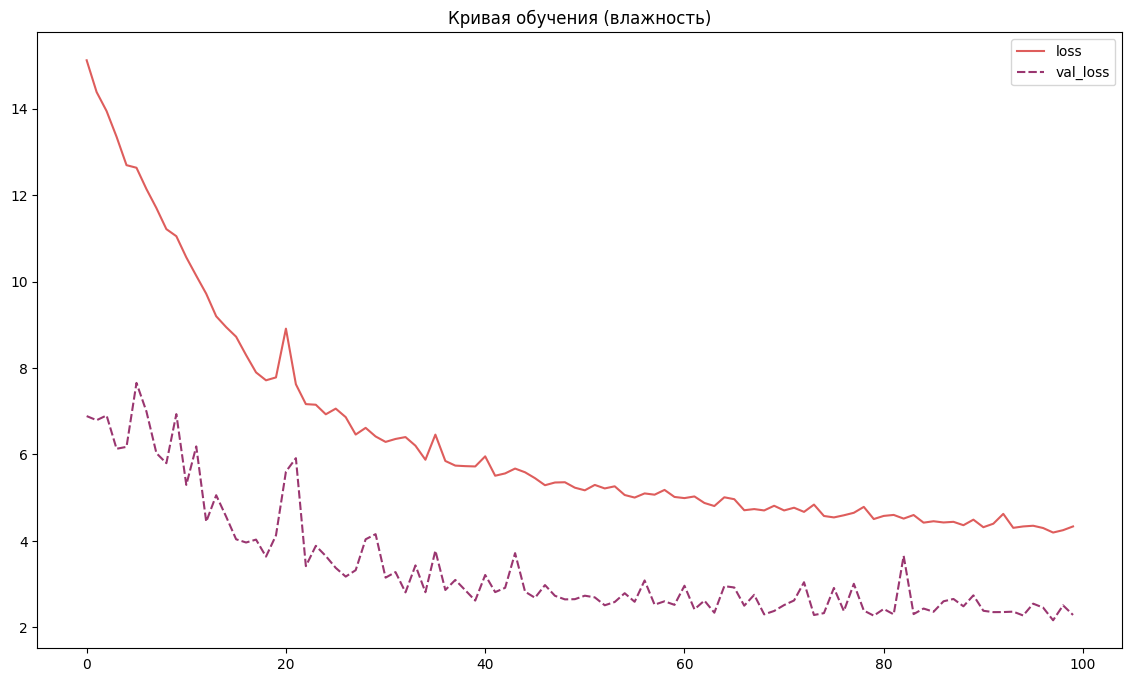

In [55]:
# Строим кривую обучения модели
print('MAPE on train:     ', mape(y_hum_train, RNN.predict(X_train_reshaped)))
print('MAPE on validation:', mape(y_hum_valid, RNN.predict(X_valid_reshaped)))

his_hum = pd.DataFrame(history_hum.history)
history_loss_hum = his_hum[['loss', 'val_loss']]

plt.figure(figsize=(14,8))
plt.title('Кривая обучения (влажность)')
sns.lineplot(history_loss_hum, palette='flare')

In [56]:
# Сохраняем предсказания
X_forward = np.array(output_df[x_cols])
hum_prediction = RNN.predict(X_forward.reshape(X_forward.shape[0], X_forward.shape[1], 1)).flatten()
safe_save('humidity', hum_prediction)

141/141 [==============================] - 1s 7ms/step


# "Проблемные" столбцы

In [238]:
# Скорость ветра в целом +/- постоянна и хорошо аппроксимируется медианой с последнего часа
# В качестве продвинутого решения - бустинг, который берет в качестве аргументов дополнительно
# температуру, давление и влажность. Соответственно кормить его будем предсказаниями с этих трех столбцов
# Работает чуууть-чуть лучше просто медианы
X_wind_s = np.array(input_df[['day', 'time', 'y', 'x', 'z', 'temperature', 'pressure', 'humidity']])
y_wind_s = np.array(input_df['wind_speed'])
X_wind_s_train, X_wind_s_valid, y_wind_s_train, y_wind_s_valid = train_test_split(X_wind_s, y_wind_s, test_size=0.25, random_state=0)

model = XGBRegressor()
model.fit(X_wind_s_train, y_wind_s_train)
print('MAPE on train:     ', mape(y_wind_s_train + 1, model.predict(X_wind_s_train) + 1))
print('MAPE on validation:', mape(y_wind_s_valid + 1, model.predict(X_wind_s_valid) + 1))

wind_speed_prediction = model.predict(np.hstack([np.array(output_df[['day', 'time', 'y', 'x', 'z']]),
                                    np.load(saving_dir_name + 'temperature.npy').reshape(-1, 1) - 1,
                                    np.load(saving_dir_name + 'pressure.npy').reshape(-1, 1) - 1,
                                    np.load(saving_dir_name + 'humidity.npy').reshape(-1, 1) - 1
                                    ]))

# Это просто медиана с последнего часа
#wind_speed_prediction = np.median(input_df[(input_df['day'] == 2) & (input_df['time'] == 18)]['wind_speed'])

In [239]:
# В направлении ветра есть опасность получить огромную ошибку MAPE при низкой фактической.
# Поэтому лучшее константное решение - это минимум за последний час.
# Ниже честная попытка предсказать направление ветра по имеющимся предсказаниям трех нормальных столбцов
X_wind = np.array(input_df[['day', 'time', 'y', 'x', 'z', 'temperature', 'pressure', 'humidity']])
y_wind = np.array(input_df['wind_dir'])
X_wind_train, X_wind_valid, y_wind_train, y_wind_valid = train_test_split(X_wind, y_wind, test_size=0.25, random_state=0)

model = LinearRegression()
model.fit(X_wind_train, y_wind_train)
print('MAPE on train:     ', mape(y_wind_train, model.predict(X_wind_train)))
print('MAPE on validation:', mape(y_wind_valid, model.predict(X_wind_valid)))

wind_dir_prediction = model.predict(np.hstack([np.array(output_df[['day', 'time', 'y', 'x', 'z']]),
                                    np.load(saving_dir_name + 'temperature.npy').reshape(-1, 1) - 1,
                                    np.load(saving_dir_name + 'pressure.npy').reshape(-1, 1) - 1,
                                    np.load(saving_dir_name + 'humidity.npy').reshape(-1, 1) - 1
                                    ]))
# Здесь разные модели периодически активно предсказывают отрицательные значения, чтобы от этого избавиться, вычитаем минимум
wind_dir_prediction = wind_dir_prediction - np.min(wind_dir_prediction)

# Проблема в том, что результат получается сильно распредленным. В итоге лучшие показатели выходят,
# если использовать просто медиану из этого предсказания в качестве константы,
# дополнительно занизив ее на стандартное отклонение (потому что здесь у нас данные могут быть близки к нулю,
# и из-за MAPE нам лучше предсказание занизить, чем завысить).
# Немного лучше минимума за последний час
wind_dir_prediction = np.median(wind_dir_prediction) - np.std(wind_dir_prediction)

# Ну а это тот самый минимум
#wind_dir_prediction = np.min(input_df[(input_df['day'] == 2) & (input_df['time'] >= 16)]['wind_dir'])

MAPE on train:      0.21752697812425148
MAPE on validation: 0.21232916451581638


In [243]:
# По графику медианной облачности видно, что в целом она имеет суточный режим,
# при этом имея явный возрастающий тренд. Поэтому ее мы построим следующим образом. Возьмем распределение за последние
# 5 часов предыдущего дня (то есть ровно сутки назад) и поднимем на минимальное значение с последнего часа
cloud_cover_prediction = (np.min(input_df[(input_df['day'] == 2) & (input_df['time'] == 18)]['cloud_cover']) +
                          np.array(input_df[(input_df['day'] == 1) & (input_df['time'] > 18)]['cloud_cover']) -
                          np.min(input_df[(input_df['day'] == 1) & (input_df['time'] > 18)]['cloud_cover']))

# Формируем submission

In [252]:
# Вспоминаем, что надо вычесть единицу
output_df['temperature'] = np.load(saving_dir_name + 'temperature.npy') - 1
output_df['pressure'] = np.load(saving_dir_name + 'pressure.npy') - 1
output_df['humidity'] = np.load(saving_dir_name + 'humidity.npy') - 1

# И заполняем проблемные столбцы, здесь уже вычить ничего не надо
output_df['wind_speed'] = wind_speed_prediction
output_df['wind_dir'] = wind_dir_prediction
output_df['cloud_cover'] = cloud_cover_prediction

# Проверка
output_df

,day,time,y,x,z,temperature,pressure,humidity,wind_speed,wind_dir,cloud_cover
0,2,19,1,1,129.0,22.378513,1001.363464,82.419838,8.516747,9.105877,11.0
1,2,19,1,2,116.0,22.292713,1001.364441,83.485359,8.580746,9.105877,11.0
2,2,19,1,3,113.0,22.161129,1001.371216,83.991966,8.525375,9.105877,11.0
3,2,19,1,4,115.0,21.999929,1001.382935,83.966255,8.455170,9.105877,12.0
4,2,19,1,5,122.0,21.843735,1001.387512,83.748825,8.645815,9.105877,12.0
...,...,...,...,...,...,...,...,...,...,...,...
4495,2,23,30,26,134.0,20.137739,1000.364807,85.476257,7.166653,9.105877,14.0
4496,2,23,30,27,110.0,20.135153,1000.456604,85.059662,5.533296,9.105877,31.0
4497,2,23,30,28,109.0,20.131218,1000.429932,84.706490,5.653350,9.105877,31.0
4498,2,23,30,29,124.0,20.125149,1000.482056,84.439362,6.079309,9.105877,31.0


In [253]:
output_df.describe()

,day,time,y,x,z,temperature,pressure,humidity,wind_speed,wind_dir,cloud_cover
count,4500.0,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,2.0,21.000000,15.500000,15.500000,123.945557,20.591249,1000.801086,85.844345,8.077439,9.105877,21.557333
std,0.0,1.414371,8.656403,8.656403,36.031963,0.492533,0.391457,2.256051,1.636925,0.000000,10.208367
min,2.0,19.000000,1.000000,1.000000,63.000000,19.943817,1000.073669,79.702621,2.025696,9.105877,11.000000
25%,2.0,20.000000,8.000000,8.000000,95.000000,20.242376,1000.515823,84.254667,7.052263,9.105877,12.000000
50%,2.0,21.000000,15.500000,15.500000,118.500000,20.452393,1000.683319,85.900757,8.154850,9.105877,19.000000
75%,2.0,22.000000,23.000000,23.000000,147.000000,20.738067,1001.103607,87.813585,9.147289,9.105877,30.000000
max,2.0,23.000000,30.000000,30.000000,235.000000,22.583952,1001.888062,89.954285,13.850090,9.105877,44.000000


In [254]:
# Сохраняем в файлик
output_df.iloc[:, 5:].to_csv('submission_finaaaaaaaaal.csv', index_label='ID')